https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification

# **Проект "Классификация твитов о коронавирусе с TF-IDF"**

# Импортирование библиотек

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

import nltk
from collections import defaultdict

from nltk.corpus import stopwords
nltk.download('stopwords')
stop = set(stopwords.words('english'))

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [68]:
train = pd.read_csv('Corona_NLP_train.csv', encoding='latin1')
test = pd.read_csv('Corona_NLP_test.csv', encoding='latin1')

train.rename(columns = {'OriginalTweet' : 'text'}, inplace = True) 
test.rename(columns = {'OriginalTweet' : 'text'}, inplace = True) 
train.columns = train.columns.str.lower()
test.columns = test.columns.str.lower()
train['sentiment'] = train['sentiment'].str.lower()
test['sentiment'] = test['sentiment'].str.lower()

df=pd.concat([train,test])
display(df)

,username,screenname,location,tweetat,text,sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",extremely negative
...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,positive
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,negative
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,neutral
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,extremely negative


# Предварительный анализ и подготовка данных

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44955 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   username    44955 non-null  int64 
 1   screenname  44955 non-null  int64 
 2   location    35531 non-null  object
 3   tweetat     44955 non-null  object
 4   text        44955 non-null  object
 5   sentiment   44955 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.4+ MB


In [70]:
print(f'Размер данных ', df.shape)

Размер данных  (44955, 6)


## Проверка на дубликаты

In [71]:
df.drop_duplicates()
print(f"Размер данных после удаления дубликатов:", df.shape)

Размер данных после удаления дубликатов: (44955, 6)


In [72]:
print(f'Всего твитов в данных:', df.shape[0])
print('Всего уникальных пользователей в данных: {}'.format(df['username'].nunique()))

Всего твитов в данных: 44955
Всего уникальных пользователей в данных: 44955


In [73]:
print('Всего меток твитов в данных: {}'.format(len(df['sentiment'].unique())))
print('Уникальные метки твитов: {}'.format(df['sentiment'].unique()), end = '\n\n')
print('Количество меток каждого типа твитов:\n{}'.format(df['sentiment'].value_counts()))

Всего меток твитов в данных: 5
Уникальные метки твитов: ['neutral' 'positive' 'extremely negative' 'negative' 'extremely positive']

Количество меток каждого типа твитов:
positive              12369
negative              10958
neutral                8332
extremely positive     7223
extremely negative     6073
Name: sentiment, dtype: int64


## Пропуски в данных

In [74]:
nan_df = pd.DataFrame(data = df.isnull().sum(), columns = ['total_nan'])
nan_df

,total_nan
username,0
screenname,0
location,9424
tweetat,0
text,0
sentiment,0


Пропуски есть только в признаке "Location", который по большому счету не влияет на метку текста. Будем исходить из предположения о том, что на метку текста влияет только содержание текста.

# Разведочный анализ данных

Посмотрим на то, как распределены метки в данных, тренировочной и тестовой подвыборках, на распределение символов и слов в текстах с соответствующими метками и на другие распределения, который способны дать более менее полезную информацию о данных.

## Распределение меток текстов

In [75]:
target_distr = pd.DataFrame(data=df.groupby('sentiment')['sentiment'].count())
target_distr.columns = ['count']
target_distr = target_distr.sort_values(by = 'count', ascending=False)
target_distr

,count
sentiment,
positive,12369
negative,10958
neutral,8332
extremely positive,7223
extremely negative,6073


In [76]:
target_distr.count

<bound method DataFrame.count of                     count
sentiment                
positive            12369
negative            10958
neutral              8332
extremely positive   7223
extremely negative   6073>

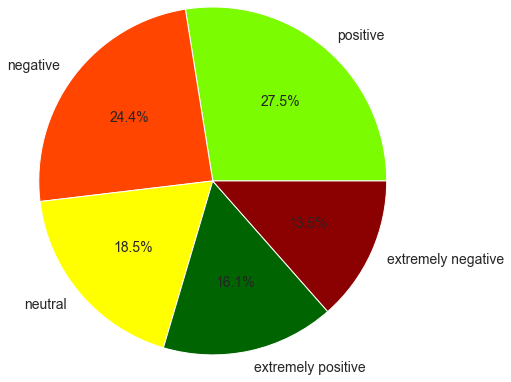

In [77]:
percent_class = list(target_distr['count'])
labels = list(target_distr.index)

colors = ['lawngreen', 'orangered','yellow','darkgreen', 'darkred']

plt.pie(percent_class,radius = 2, labels=labels, colors=colors, autopct='%1.1f%%', textprops={'fontsize': 14})

plt.show()

## Распределение меток текстов в тренировочной и тестовой подвыборках

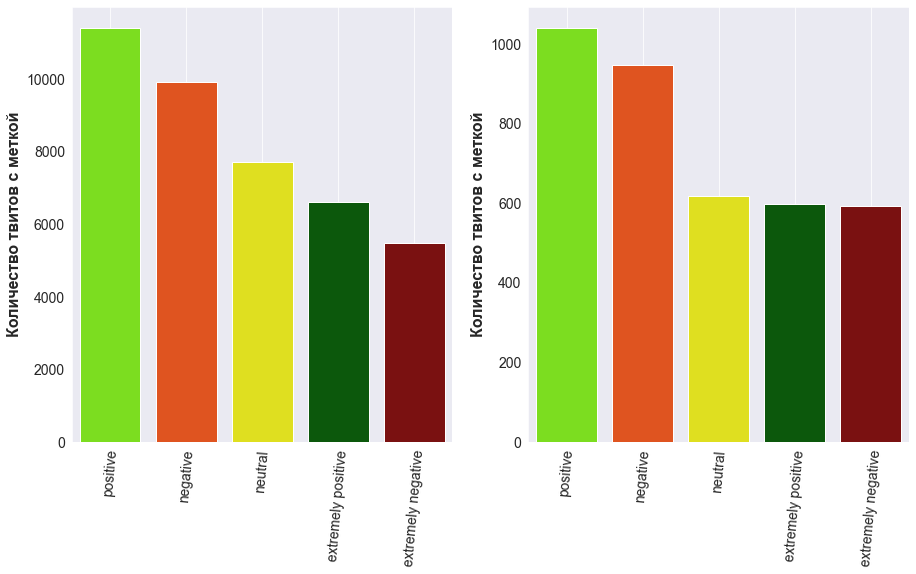

In [78]:
sns.set_style('darkgrid')

plt.figure(figsize = (15, 8))
plt.subplot(121)
ax1 = sns.barplot(x=labels, y=train['sentiment'].value_counts().values, palette = colors)
plt.xticks(fontsize = 14, rotation = 85)
plt.yticks(fontsize = 14)
plt.ylabel('Количество твитов с меткой', fontsize = 16, fontweight = 'bold')
ax1.grid()

plt.subplot(122)
ax2 = sns.barplot(x=labels, y=test['sentiment'].value_counts().values, palette = colors)
plt.xticks(fontsize = 14, rotation = 85)
plt.yticks(fontsize = 14)
plt.ylabel('Количество твитов с меткой', fontsize = 16, fontweight = 'bold')
ax2.grid()
plt.show()

Классы достаточно неплохо сбалансированы, максимальное отличие не более чем в 2 раза, а значит даже классические классификаторы должны работать неплохо, нейросети так и подавно. Распределение меток в тренировочном и тестовом датасетах также не критично отличаются друг от друга.

## Распределение количества симовлов в текстах

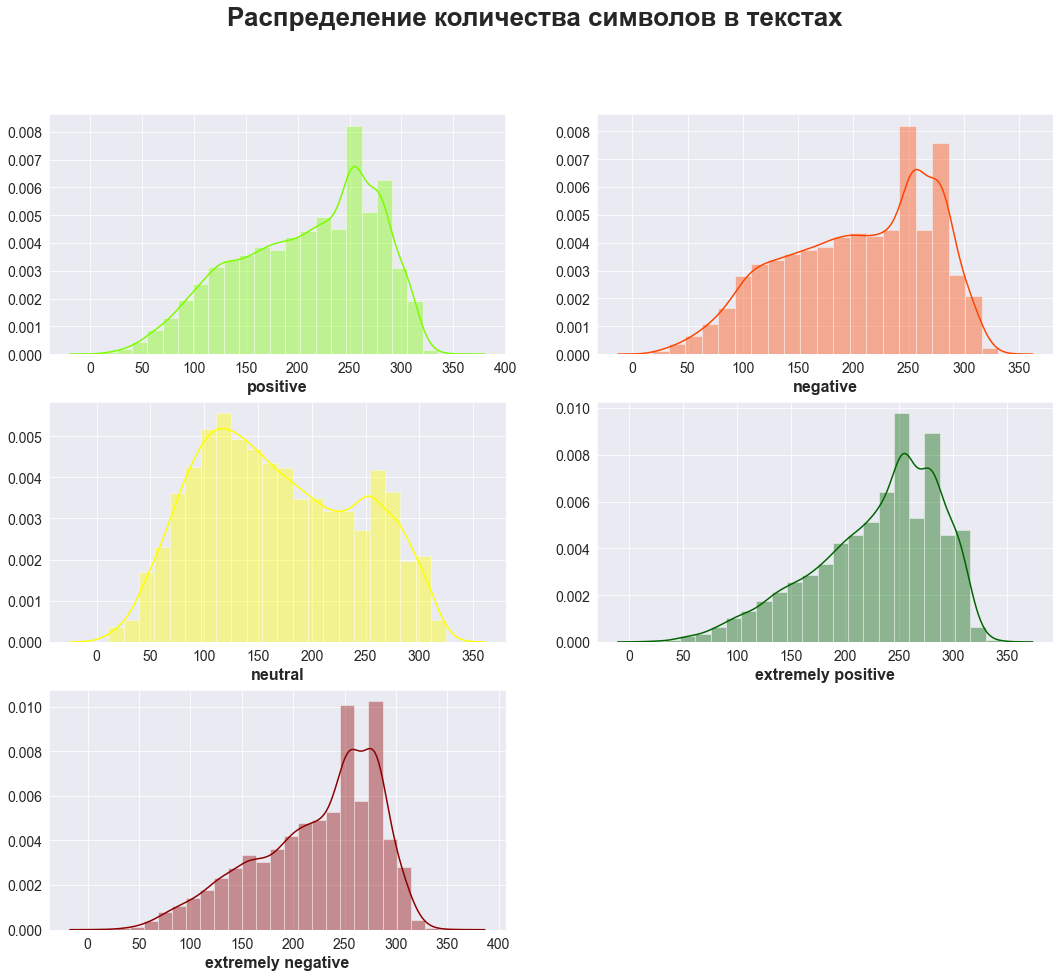

In [79]:
plt.figure(figsize=(18, 15))
plt.suptitle('Распределение количества символов в текстах', fontsize = 26, fontweight = 'bold')

for index, sentiment in enumerate(labels):
    plt.subplot(3, 2, index+1)
    tweet_len_char=df[df['sentiment']==sentiment]['text'].str.len() # Количество символов в твите
    sns.distplot(a=tweet_len_char, bins=int((max(tweet_len_char) - min(tweet_len_char)) /
             (1 + 3.322*np.log10(len(tweet_len_char)))), color=colors[index]) 

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel(sentiment, fontsize=16, fontweight='bold')
    plt.ylabel('')
plt.show()

В текстах с нейтральным окрасом количество символов в среднем меньше, в остальных видах текста по эмоциональному окрасу распределения примерно одинаковы.

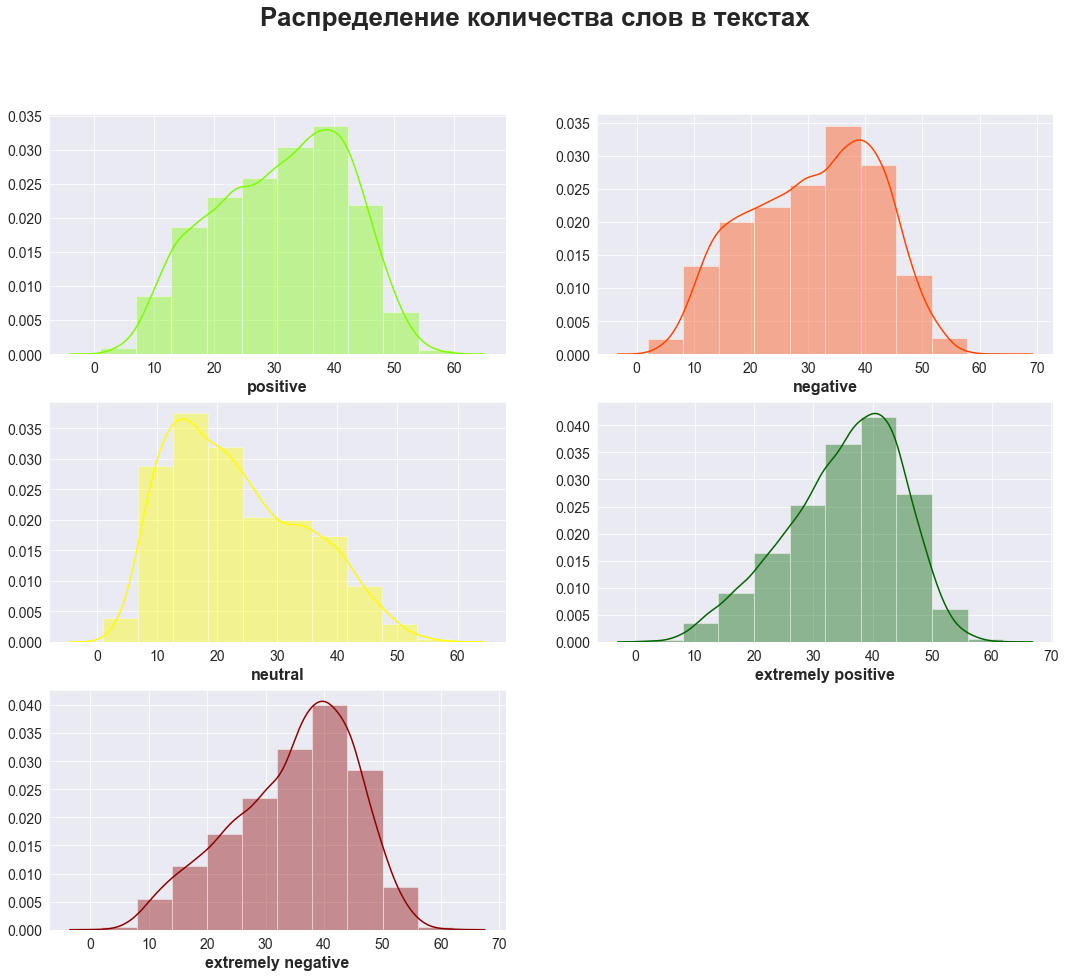

In [80]:
plt.figure(figsize=(18, 15))
plt.suptitle('Распределение количества слов в текстах',
             fontsize=26, fontweight='bold')

for index, sentiment in enumerate(labels):
    plt.subplot(3, 2, index+1)
    tweet_len_word = df[df['sentiment'] == sentiment]['text'].str.split().apply(
        lambda x: [len(i) for i in x]).map(lambda x: len(x)) # количество слов в твите
    sns.distplot(a=tweet_len_word, bins=10, color=colors[index])

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel(sentiment, fontsize=16, fontweight='bold')
    plt.ylabel('')
plt.show()

Распределения примерно схожи с распределениями для количества символов. Количество слов в текстах с нейтральным эмоциональным окрасом заметно меньше, чем в других текстах.

## Популярность слов в твитах(без учета стоп-слов)

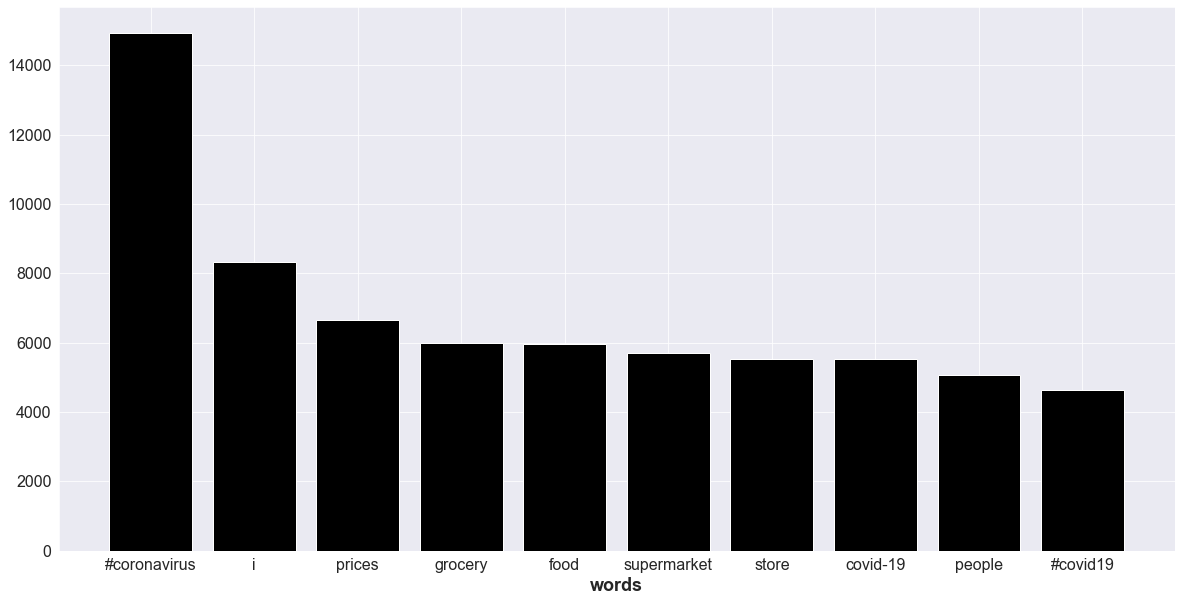

In [81]:
plt.figure(figsize = (20, 10))
corpus=[]
comment_words = '' 

for x in train['text'].str.split():
    for i in x:
        corpus.append(i)

dic=defaultdict(int)
for word in corpus:
    if word not in stop:
        dic[word.lower()]+=1     
        
top=sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10] 
x, y = zip(*top)

plt.bar(x, y, color = 'black')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('words', fontsize = 18, fontweight = 'bold')
plt.show()

## Популярность хэштегов(#) в твитах

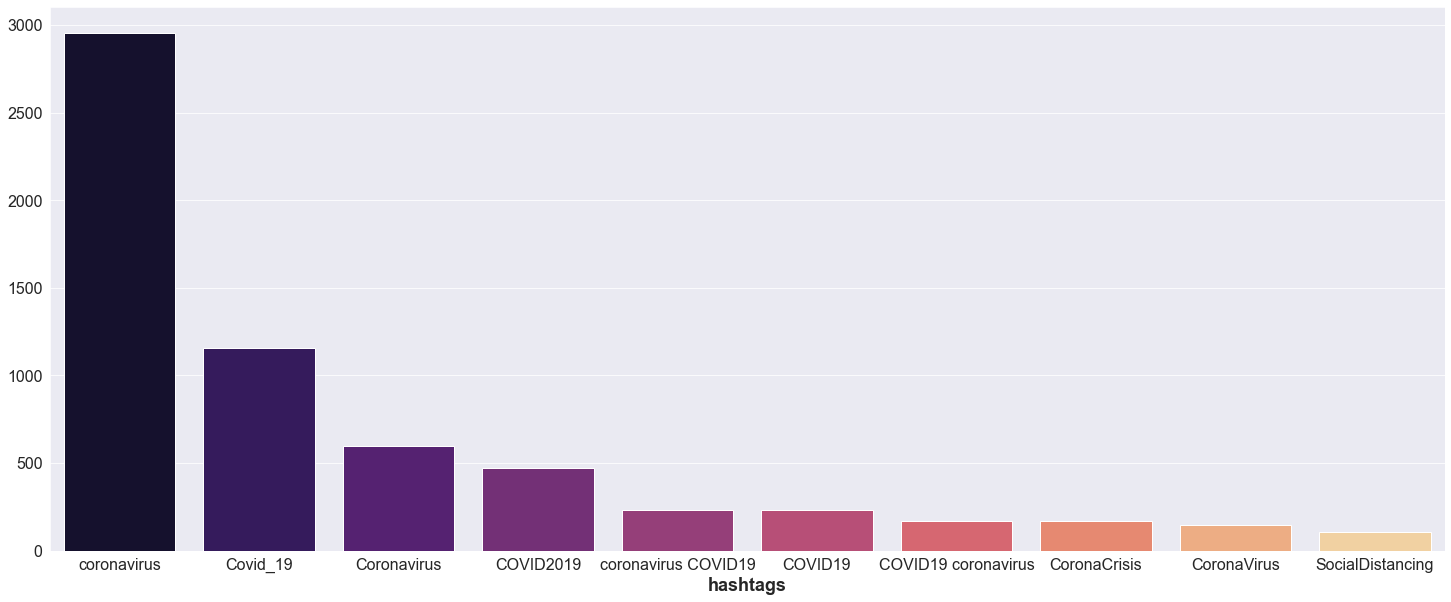

In [82]:
def find_hash(text):
    line=re.findall(r'(?<=#)\w+',text)
    return " ".join(line)

df['hash']=df['text'].apply(lambda x: find_hash(x))
temp = df['hash'].value_counts()[1:11]
temp = temp.to_frame().reset_index().rename(columns={'index':'Hashtag','hash':'count'})

plt.figure(figsize = (25, 10))
sns.barplot(x="Hashtag", y="count", data = temp, palette = 'magma')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('hashtags', fontsize = 18, fontweight = 'bold')
plt.ylabel('')
plt.show()

## Популярность отсылок(@) в твитах

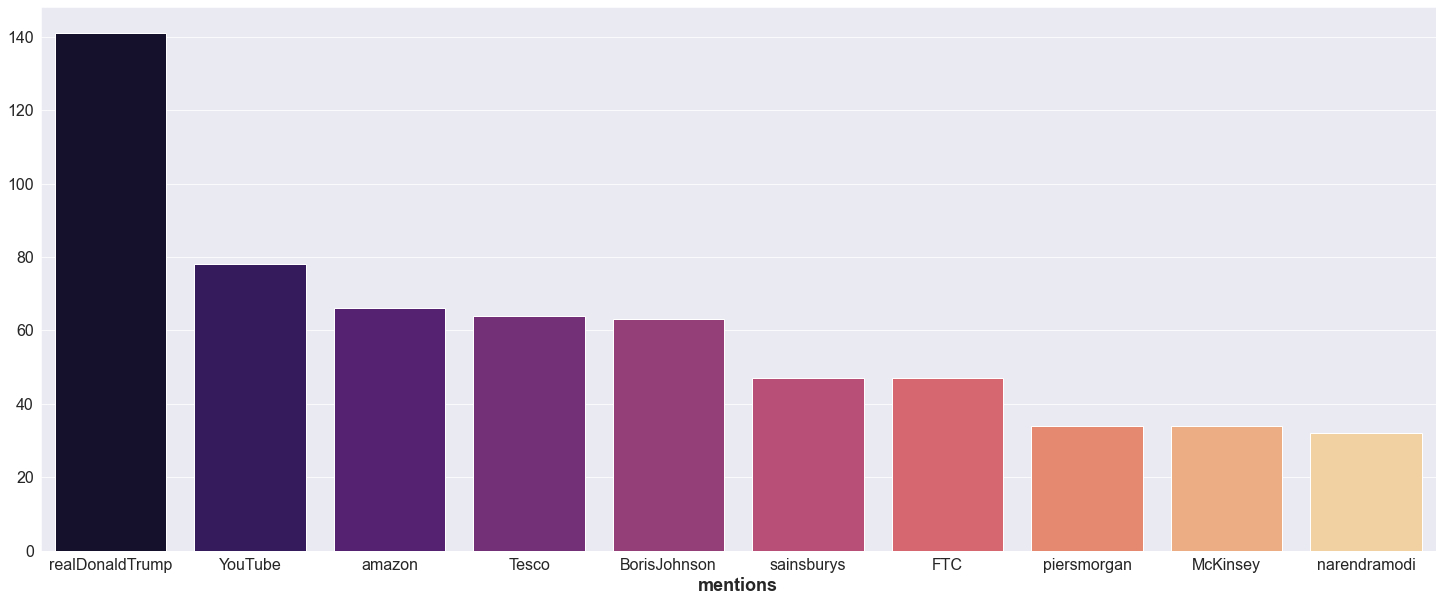

In [83]:
def mentions(text):
    line=re.findall(r'(?<=@)\w+',text)
    return " ".join(line)

df['mentions']=df['text'].apply(lambda x: mentions(x))
temp = df['mentions'].value_counts()[1:11]
temp = temp.to_frame().reset_index().rename(columns={'index':'mentions','mentions':'count'})

plt.figure(figsize = (25, 10))
sns.barplot(x='mentions',y='count', data = temp, palette = 'magma')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('mentions', fontsize = 18, fontweight = 'bold')
plt.ylabel('')
plt.show()

# Предобработка данных 

Итак, имеется исходный датафрейм df, в котором признак text соответствует твиту определенного пользователя, то есть это тип данных object, прежде чем приступить к работе с этими твитами, нужно нормализовать текст и каждый твит представить в виде набора нормализованных слов, а также убрать слишком часто встречающиеся слова и слишком редкие слова. 

## Понижение регистра слов

In [84]:
def lower(text):
    low_text = text.lower()
    return low_text
df['text_new'] = df['text'].apply(lambda x:lower(x))

## Исключение бесполезных слов и других конструкций

### Исключение из твитов слов, состоящих только из цифр, то есть цифр в принципе

In [85]:
def remove_num(text):
    remove = re.sub(r'\d+', '', text)
    return remove
df['text_new']=df['text_new'].apply(lambda x:remove_num(x))

### Исключение ссылок на сайты(https:+ www.+) и html ссылок

In [86]:
def remove_urls(text):
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    return url_remove.sub(r'', text)
df['text_new'] = df['text_new'].apply(lambda x:remove_urls(x))

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
df['text_new']=df['text_new'].apply(lambda x:remove_html(x))

### Исключение пунктуационных знаков

In [87]:
def punct_remove(text):
    punct = re.sub(r"[^\w\s\d]","", text)
    return punct
df['text_new']=df['text_new'].apply(lambda x:punct_remove(x))

### Исключение стоп-слов(слов, которые почти не характеризуют специфику конкретного текста)

In [88]:
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
df['text_new']=df['text_new'].apply(lambda x:remove_stopwords(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Исключение хэштегов(#) и отсылок(@) в твитах

In [89]:
def remove_hash(x):
    text=re.sub(r'#\w+','',x)
    return text
df['text_new']=df['text_new'].apply(lambda x:remove_hash(x))

def remove_mention(x):
    text=re.sub(r'@\w+','',x)
    return text
df['text_new']=df['text_new'].apply(lambda x:remove_mention(x))

### Удаление "длинных пробелов"(в случае, если при обработке таковые возникли)

In [90]:
def remove_space(text):
    space_remove = re.sub(r"\s+"," ", text).strip()
    return space_remove
df['text_new']=df['text_new'].apply(lambda x:remove_space(x))

df = df.drop(columns=['text']) 

# Векторизация и нормализация, построение модели лог. регрессии

In [91]:
from sklearn.model_selection import train_test_split

In [92]:
X = df['text_new']
y = df['sentiment']

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [94]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [95]:
model = Pipeline([('tfidf',TfidfVectorizer()), ('log_regression', LogisticRegression())])

In [96]:
model.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('log_regression', LogisticRegression())])

# Метрики качества логистической регрессии

In [97]:
from sklearn.metrics import classification_report, confusion_matrix

In [98]:
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

                    precision    recall  f1-score   support

extremely negative       0.61      0.47      0.53      1189
extremely positive       0.69      0.53      0.60      1457
          negative       0.51      0.52      0.52      2204
           neutral       0.63      0.66      0.64      1681
          positive       0.52      0.63      0.57      2460

          accuracy                           0.57      8991
         macro avg       0.59      0.56      0.57      8991
      weighted avg       0.58      0.57      0.57      8991

[[ 553   11  496   53   76]
 [  14  771   51   46  575]
 [ 266   51 1155  281  451]
 [  19   11  238 1111  302]
 [  52  275  305  285 1543]]


Засчет векторизации по TF-IDF и обучения соответствующих векторизированных текстов моделью логистической регрессии удалось добиться метрики качества f1-score = 0.57.

### *Комментарии по проекту: 1) Текст не нуждался в предварительной предобработке в формат данных, пригодный для решения задачи классификации текстов. 2) Задача решалась векторизацией по TF-IDF с последующей классификацией логистической регрессией, хотя, вообще говоря, работа шла с твитами, которые представляют из себя короткие тексты(максимум несколько предложений) и TF-IDF не способна выявить большую часть скрытых паттернов текстов, она пользуется лишь методом "мешка слов", поэтому качество классификации достаточно низкое. 3) Также не использовались N-граммы символов, что также повлияло на качество модели.*